###  Modèle type LeNet ajout des données de la base APL_AML

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
import tensorflow as tf


#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [2]:
data = pd.read_csv('../base_10_class.csv',index_col=0)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31735 entries, 0 to 31734
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  31735 non-null  object
 1   filename   31735 non-null  object
 2   class      31735 non-null  object
dtypes: object(3)
memory usage: 991.7+ KB


In [4]:
data = data.drop(data[(data['class']=='blast' ) | (data['class']=='smudge')].index)

In [5]:
lst_classes = {'basophil':0,'eosinophil':1,
               'erythroblast':2,'ig':3,'lymphocyte':4,'monocyte':5,'neutrophil':6,'platelet':7}

In [6]:
data['label'] = data['class'].apply(lambda cat: lst_classes[cat])

In [7]:
data.head()

,file_path,filename,class,label
0,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_100102.jpg,basophil,0
1,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_101381.jpg,basophil,0
2,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_101611.jpg,basophil,0
3,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_102039.jpg,basophil,0
4,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_102750.jpg,basophil,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25530 entries, 0 to 31695
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  25530 non-null  object
 1   filename   25530 non-null  object
 2   class      25530 non-null  object
 3   label      25530 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 997.3+ KB


In [9]:
data['class'].value_counts()

neutrophil      5400
lymphocyte      4618
ig              3815
eosinophil      3225
monocyte        2719
platelet        2414
erythroblast    2068
basophil        1271
Name: class, dtype: int64

In [10]:
data_train, data_eval = train_test_split(data,test_size=0.1,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.1,random_state=123)

##### Mise au format Tensor

In [11]:
def load_and_preprocess(img_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224,224]) 
    img = tf.cast(img, tf.float32)/255
    return img

In [12]:
AUTO = tf.data.experimental.AUTOTUNE

In [13]:
dataset_train = tf.data.Dataset.from_tensor_slices((data_train['file_path'],data_train['label']))
dataset_test = tf.data.Dataset.from_tensor_slices((data_test['file_path'],data_test['label']))

dataset_train = (dataset_train.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(1000).batch(32))
dataset_test = (dataset_test.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).shuffle(500).batch(32))

#### Modèle type LeNet
* Couches Dense 1024, 512, 256 
* Dropout pour éviter overfitting
* Compilation avec Adam

In [14]:
# Création Callback pour stopper si stagnation
callback = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)

In [15]:
# Création d'un modèle CNN type LeNet
def model_CNN():
    model =  Sequential()
    model.add(Conv2D(filters = 30  , kernel_size=(5,5), padding='valid', input_shape=(224,224,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters = 16  , kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.2))
    model.add(Flatten())
    model.add(Dense(units=1024,activation='relu'))
    model.add(Dense(units=512,activation='relu'))
    model.add(Dense(units=256,activation='relu'))
    model.add(Dense(units=8,activation='softmax')) #8Classes
    #Compilation
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [16]:
model = model_CNN()

In [17]:
#Entrainement
history = model.fit(dataset_train, epochs = 16, validation_data = dataset_test,callbacks=[callback])

Epoch 1/16
647/647 [==============================] - 1019s 2s/step - loss: 0.9382 - accuracy: 0.6692 - val_loss: 0.5295 - val_accuracy: 0.8225
Epoch 2/16
647/647 [==============================] - 1013s 2s/step - loss: 0.5029 - accuracy: 0.8314 - val_loss: 0.3880 - val_accuracy: 0.8664
Epoch 3/16
647/647 [==============================] - 1013s 2s/step - loss: 0.3858 - accuracy: 0.8711 - val_loss: 0.4250 - val_accuracy: 0.8481
Epoch 4/16
647/647 [==============================] - 1017s 2s/step - loss: 0.3038 - accuracy: 0.8985 - val_loss: 0.3436 - val_accuracy: 0.8773
Epoch 5/16
647/647 [==============================] - 986s 2s/step - loss: 0.2468 - accuracy: 0.9181 - val_loss: 0.3394 - val_accuracy: 0.8808
Epoch 6/16
647/647 [==============================] - 980s 2s/step - loss: 0.1904 - accuracy: 0.9367 - val_loss: 0.3429 - val_accuracy: 0.8864
Epoch 7/16
647/647 [==============================] - 979s 2s/step - loss: 0.1400 - accuracy: 0.9542 - val_loss: 0.3284 - val_accuracy: 0.

#### Prédiction sur les données d'évaluation

In [18]:
dataset_eval = tf.data.Dataset.from_tensor_slices((data_eval['file_path'],data_eval['label']))
dataset_eval = (dataset_eval.map(lambda x, y : [load_and_preprocess(x), y], num_parallel_calls=AUTO).prefetch(AUTO).batch(32))

In [19]:
model.evaluate(dataset_eval)

80/80 [==============================] - 40s 498ms/step - loss: 0.3949 - accuracy: 0.8782


[0.3948647975921631, 0.8781825304031372]

 * Score de 88%, 4% de moins qu'avec la base seule Mendeley, alors qu'il y a désormais plus d'images...
> Problème dans les données de la base apl aml?

In [20]:
#Classes prédites
predict = model.predict(dataset_eval)

In [21]:
lst_classes = ['basophil','eosinophil',
               'erythroblast','ig','lymphocyte','monocyte','neutrophil','platelet']
eval_predict_class = predict.argmax(axis = 1)
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in data_eval['label'] ]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.98      0.84      0.90       118
  eosinophil       0.99      0.89      0.94       322
erythroblast       0.87      0.89      0.88       227
          ig       0.72      0.83      0.77       413
  lymphocyte       0.91      0.92      0.92       470
    monocyte       0.79      0.78      0.79       269
  neutrophil       0.91      0.89      0.90       507
    platelet       0.99      0.94      0.96       227

    accuracy                           0.88      2553
   macro avg       0.90      0.87      0.88      2553
weighted avg       0.88      0.88      0.88      2553



> Baisse du score sur toutes les classes, surtout erythroblast et IG (-10%)

In [22]:
pd.crosstab(pd.Series(eval_class_name, name='Réalité'),pd.Series(eval_predict_class_name, name='Prédiction'))

Prédiction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Réalité,,,,,,,,
basophil,99,1,0,14,0,1,3,0
eosinophil,1,288,0,11,0,1,21,0
erythroblast,0,0,202,3,18,0,2,2
ig,1,1,2,344,12,41,12,0
lymphocyte,0,0,8,15,434,7,5,1
monocyte,0,0,5,50,5,209,0,0
neutrophil,0,0,7,40,3,4,453,0
platelet,0,0,8,0,6,0,0,213


> Confusion importante neutrophil/IG ainsi que monocyte/IG

In [28]:
model.save_weights("cnn_8_weights_2_bases")


### GRAD CAM

In [23]:
import gradcam_dataset

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 30)      2280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 30)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 16)      4336      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 54, 54, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46656)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4

In [25]:
img_size = (255, 255)
last_conv_layer_name = "conv2d_1"

##### BASOPHIL

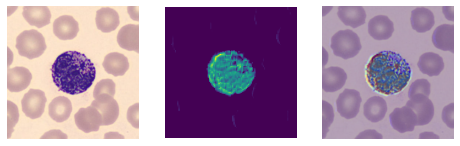

In [26]:
path = data[data['filename']=='BA_799126.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=0)

##### EOSINOPHIL

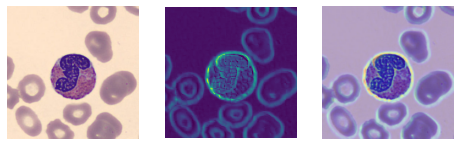

In [27]:
path = data[data['filename']=='EO_336686.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=1)

##### ERYTHROBLAST

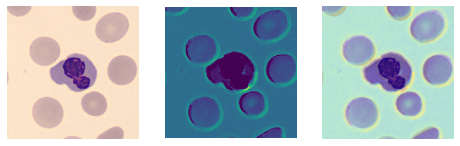

In [28]:
path = data[data['filename']=='ERB_763618.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=2)

##### IG

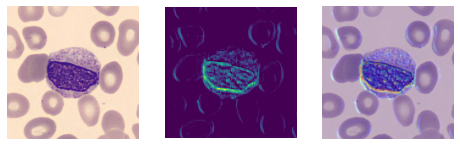

In [29]:
path = data[data['filename']=='MMY_353176.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=3)

##### LYMPHOCYTE

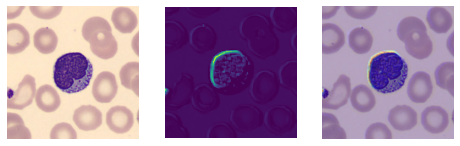

In [30]:
path = data[data['filename']=='LY_875873.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=4)

##### MONOCYTE

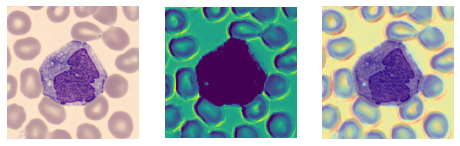

In [31]:
path = data[data['filename']=='MO_60562.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=5)

##### NEUTROPHIL

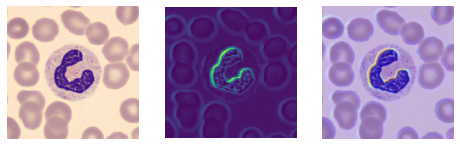

In [32]:
path = data[data['filename']=='BNE_53394.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=6)

##### PLATELET

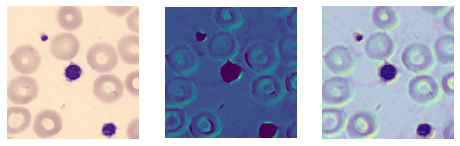

In [33]:
path = data[data['filename']=='PLATELET_57415.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=7)